## 必要なライブラリのインポート

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import ast
from collections import Counter
attractions = {
    0: 'ソアリン',
    1: 'トイストーリーマニア',
    2: 'タワーオブテラー',
    3: 'センターオブジアース',
    4: 'インディジョーンズ',
    5: 'レイジングスピリッツ',
    6: 'マジックランプシアター',
    7: 'タートルトーク'
}

use_bestplan_data = 'updated_combined_data5.csv'
info_df = pd.read_csv(use_bestplan_data)
print(info_df.info())
print(info_df.dtypes)
print(info_df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12356 entries, 0 to 12355
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   日付         12356 non-null  object 
 1   トータル満足度    12356 non-null  float64
 2   トータル所要時間   12356 non-null  float64
 3   予定プラン      12356 non-null  object 
 4   最適プラン      12356 non-null  object 
 5   タイムスケジュール  12356 non-null  object 
dtypes: float64(2), object(4)
memory usage: 579.3+ KB
None
日付            object
トータル満足度      float64
トータル所要時間     float64
予定プラン         object
最適プラン         object
タイムスケジュール     object
dtype: object
(12356, 6)


## さまざまな表示用の関数

In [3]:
def not_in_new_ride(a, b):
    ans = a[:]
    for item in b:
        if item in a:
            ans.remove(item)
    return ans

def calculate_time(minutes):
    start_time = 9 * 60
    total_minutes = start_time + minutes
    hours = total_minutes // 60
    mins = total_minutes % 60
    if hours >= 24:
        hours -= 24
    return f"{hours:02d}:{mins:02d}"

def ride_printer(date, total_popularity, total_time, ride_lst, new_ride_lst, ride_time):
    print("-" * 40)
    print(f"~ {date[0]} の待ち時間データによる乗車プラン ~")
    print("乗車時間　：　アトラクション名")
    for i in range(len(new_ride_lst)):
        print(f"{calculate_time(ride_time[i])}　： {attractions.get(new_ride_lst[i])}")
    print('トータル所要時間：', total_time)
    print('トータル満足度　：', total_popularity)
    print("-" * 40)
    if len(new_ride_lst) < len(ride_lst):
        if len(ride_lst) != len(new_ride_lst):
            print("※全てのアトラクションを乗ることができません")
            print("プランから除外されたアトラクション")
            not_ride = not_in_new_ride(ride_lst, new_ride_lst)
            for i in not_ride:
                print(f"{i}　： {attractions.get(i)}")

## 推奨プランの出力

In [4]:
# レビュー評価（popularity）
popularity = [476, 465, 473, 472, 480, 452, 461, 478]

def find_optimal_plan(date, attractions):
    # データを読み込む
    file_path = use_bestplan_data
    df = pd.read_csv(file_path)
    
    # 入力のアトラクションの出現回数をカウント
    attraction_counts = Counter(attractions)
    
    # 日付でフィルタリング
    date_filtered_df = df[df['日付'] == date].copy()
    
    # '最適プラン'列をリスト形式に変換
    date_filtered_df['最適プラン'] = date_filtered_df['最適プラン'].apply(ast.literal_eval)

    # 指定アトラクションの出現回数が一致する行を抽出
    def matches_plan(optimal_plan):
        plan_counts = Counter(optimal_plan)
        return all(plan_counts.get(attraction, 0) >= count for attraction, count in attraction_counts.items())

    filtered_df = date_filtered_df[date_filtered_df['最適プラン'].apply(matches_plan)]
    
    if filtered_df.empty:
        # 条件に一致するデータがない場合の処理
        print("指定された条件に合うプランは見つかりませんでした。")
        
        # '日付'が'median'のデータを参照
        median_df = df[df['日付'] == 'median']
        median_df['最適プラン'] = median_df['最適プラン'].apply(ast.literal_eval)

        if not median_df.empty:
            max_satisfaction_plan = median_df.loc[median_df['トータル満足度'].idxmax()]
            print(f"The used file is：{file_path}")
            print(f"Its's index is：{max_satisfaction_plan.name}")

        else:
            # 全データからトータル満足度が最大のプランを選択
            df['最適プラン'] = df['最適プラン'].apply(ast.literal_eval)
            max_satisfaction_plan = df.loc[df['トータル満足度'].idxmax()]
            print(f"The used file is：{file_path}")
            print(f"Its's index is：{max_satisfaction_plan.name}")
        
        # データフレームとして返す
        return pd.DataFrame([{
            '日付': max_satisfaction_plan['日付'],
            'トータル満足度': max_satisfaction_plan['トータル満足度'],
            'トータル所要時間': max_satisfaction_plan['トータル所要時間'],
            '予定プラン': attractions,
            '最適プラン': max_satisfaction_plan['最適プラン'],
            'タイムスケジュール': max_satisfaction_plan['タイムスケジュール']
        }])
    else:
        # トータル満足度が最大のプランを取得
        max_satisfaction_plan = filtered_df.loc[filtered_df['トータル満足度'].idxmax()]
        print(f"The used file is：{file_path}")
        print(f"Its's index is：{max_satisfaction_plan.name}")
        
        # データフレームとして返す
        return pd.DataFrame([{
            '日付': max_satisfaction_plan['日付'],
            'トータル満足度': max_satisfaction_plan['トータル満足度'],
            'トータル所要時間': max_satisfaction_plan['トータル所要時間'],
            '予定プラン': attractions,
            '最適プラン': max_satisfaction_plan['最適プラン'],
            'タイムスケジュール': max_satisfaction_plan['タイムスケジュール']
        }])


def plot_waittime_and_optimal_plans(date_input, result_df):
    heatmap_csv_file = f'./waittime_heatmap_csv/{date_input}_waittime.csv'
    
    plt.rcParams['font.family'] = 'IPAexGothic'
    
    attractions = ['ソアリン', 'トイストーリーマニア', 'タワーオブテラー', 'センターオブジアース',
                   'インディジョーンズ', 'レイジングスピリッツ', 'マジックランプシアター', 'タートルトーク']

    heatmap_df = pd.read_csv(heatmap_csv_file)
    heatmap_df = heatmap_df.loc[:, ~heatmap_df.columns.str.contains('^Unnamed')]
    heatmap_data = heatmap_df.values
    heatmap_columns = heatmap_df.columns.astype(int)

    plt.figure(figsize=(20, 10))

    norm = Normalize(vmin=np.nanmin(heatmap_data), vmax=np.nanmax(heatmap_data))
    cax = plt.imshow(heatmap_data, aspect='auto', cmap='coolwarm', norm=norm, interpolation='nearest', alpha=0.8)

    time_range = range(9 * 60, 20 * 60 + 1, 15)
    x_labels = [f"{t // 60:02d}:{t % 60:02d}" for t in time_range]
    plt.xticks(range(len(x_labels)), x_labels, rotation=45, fontsize=8)
    plt.yticks(range(len(attractions)), attractions, fontsize=10)
    plt.gca().invert_yaxis()
    plt.colorbar(cax, label='混み具合').ax.tick_params(labelsize=10)

    optimal_plans_list = [ast.literal_eval(plan) if isinstance(plan, str) else plan for plan in result_df["最適プラン"]]
    time_schedule_list = [ast.literal_eval(plan) if isinstance(plan, str) else plan for plan in result_df["タイムスケジュール"]]

    for i in range(len(optimal_plans_list)):
        adjusted_time_schedule = [np.where(heatmap_columns == tick)[0][0] for tick in time_schedule_list[i]]
        plt.plot(adjusted_time_schedule, optimal_plans_list[i], marker='o', linestyle='-', 
                 label=f'Data {i+1}', color='black', markersize=6)

    plt.xlabel("時間", fontsize=14)
    plt.ylabel("アトラクション", fontsize=14)
    plt.title("アトラクションの混む時間帯と最適プラン", fontsize=16)
    plt.legend(loc='best', fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def find_and_plot_optimal_plan(date_input, attractions_input):
    # 日付を基にデータを取得
    result_df = find_optimal_plan(date_input, attractions_input)

    # 結果が空でない場合に処理を進める
    if not result_df.empty:
        # 各要素を取得1
        data1 = result_df.apply(lambda row: row.values.tolist(), axis=1).tolist()[0]
        data1 = [data1[0]] + [ast.literal_eval(item) if isinstance(item, str) else item for item in data1[1:]]
        date1 = data1[0]
        total_popularity1 = data1[1]
        total_time1 = data1[2]
        ride_lst1 = data1[3]
        new_ride_lst1 = data1[4]
        ride_time1 = data1[5]
        ride_printer(data1, total_popularity1, total_time1, ride_lst1, new_ride_lst1, ride_time1)
        
        # プロットを表示
        plot_waittime_and_optimal_plans(date_input, result_df)
    else:
        print(f"{date_input} の最適プランが見つかりませんでした。")

## 入力欄

The used file is：updated_combined_data5.csv
Its's index is：1045
----------------------------------------
~ 2022-07-06 の待ち時間データによる乗車プラン ~
乗車時間　：　アトラクション名
09:00　： マジックランプシアター
09:45　： インディジョーンズ
10:15　： レイジングスピリッツ
10:45　： トイストーリーマニア
11:30　： タワーオブテラー
12:30　： インディジョーンズ
12:45　： タワーオブテラー
13:45　： センターオブジアース
14:00　： インディジョーンズ
14:30　： センターオブジアース
15:00　： タートルトーク
16:00　： レイジングスピリッツ
16:15　： タワーオブテラー
17:00　： センターオブジアース
17:15　： レイジングスピリッツ
17:45　： センターオブジアース
18:00　： ソアリン
18:45　： センターオブジアース
19:15　： ソアリン
20:00　： センターオブジアース
トータル所要時間： 674.0
トータル満足度　： 9403.0
----------------------------------------


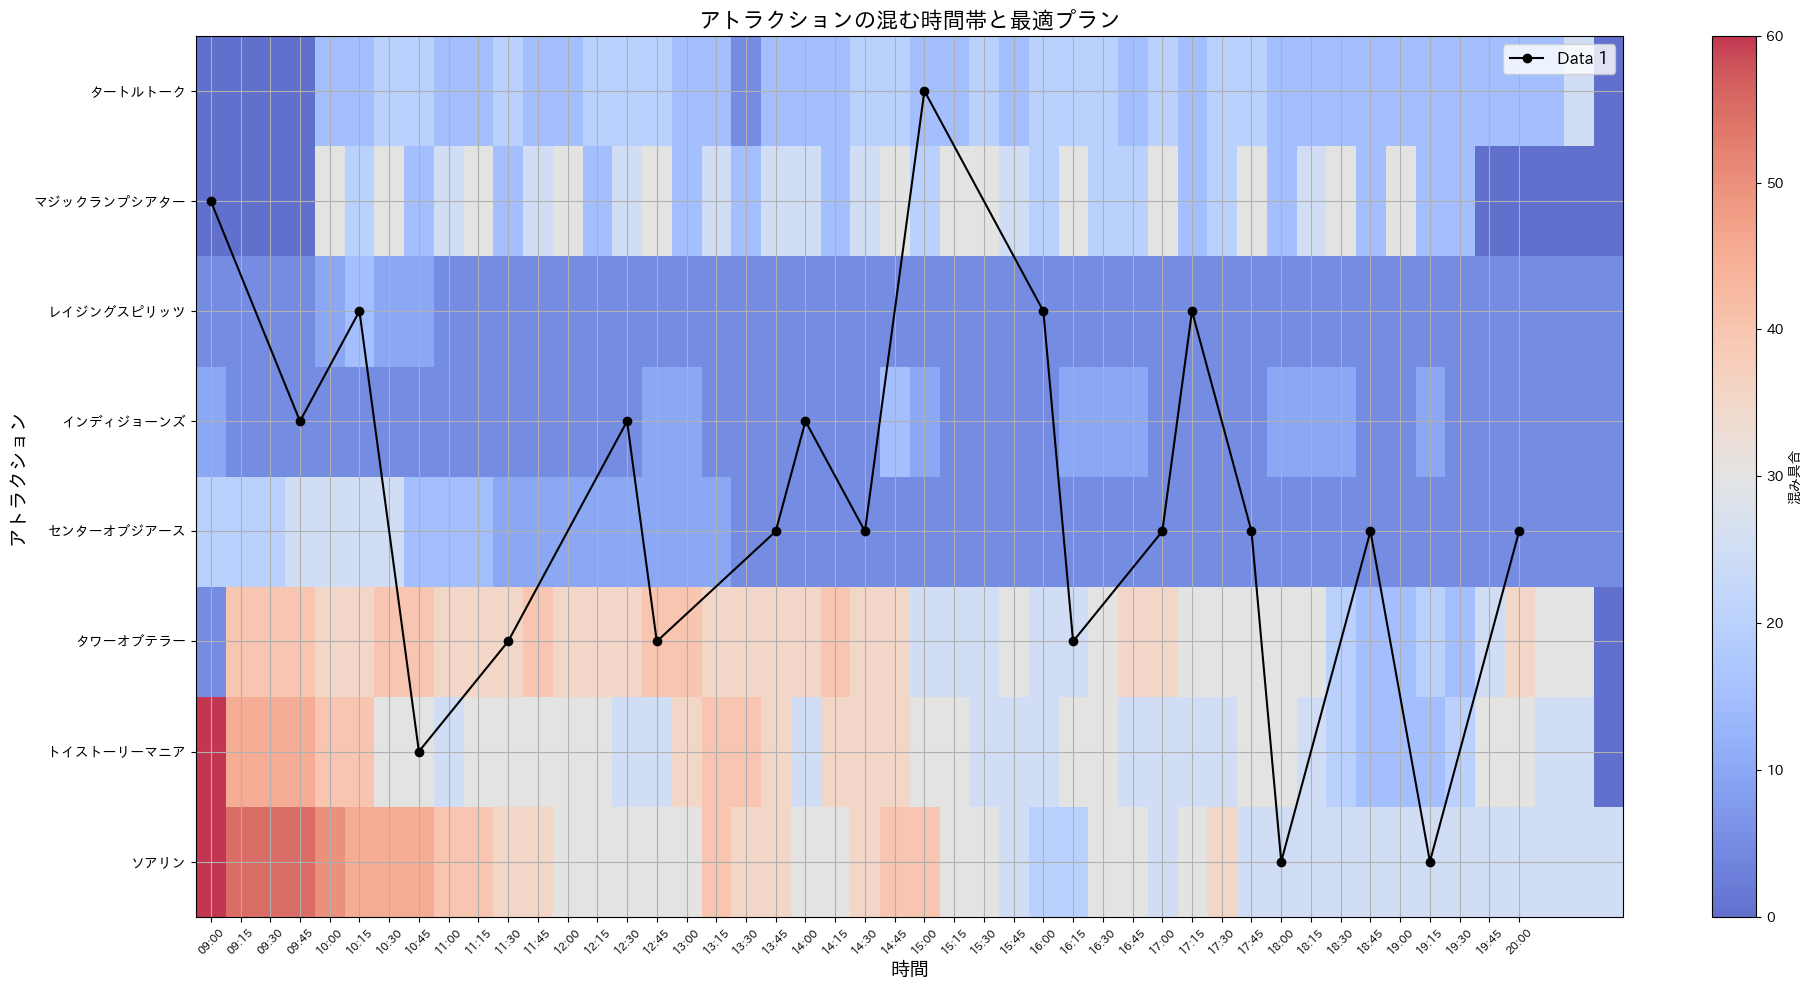

In [5]:
#日付
date_input = '2022-07-06'
#date_input = 'median'

#乗車したいアトラクション
attractions_input = [0, 1, 2, 3, 4, 5, 6, 7,]

#実行関数
find_and_plot_optimal_plan(date_input, attractions_input)